## 1. Data preprocessing ##

In [1]:
#Code from class to preprocess the image data
import os
os.chdir('D:\/Downloads-D')
import numpy as np
from glob import glob
from PIL import Image
from resizeimage import resizeimage
import numpy as np
import matplotlib.pyplot as plt
from sklearn import decomposition

#Create a function that takes in the path for images and outputs the flattened X inputs
def flatten(path):
    '''
    input: path - a string which is the path to the images 
    '''
    # create paths for all images
    man_images = glob(path)

    man_flattened = []
    # for each image path
    for path in man_images:
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                cover = resizeimage.resize_cover(image, [20, 20]) #convert to size 20,20
                # flatten the matrix to an array and append it to all flattened images
                man_flattened.append((np.array(cover).flatten(), 0))


    # Flatten it once more
    man_flattened = np.asarray(man_flattened)

    # Declare which are the X and Y inputs
    X = man_flattened[:,0]
    Y = man_flattened[:,1]
    X = np.delete(X, [987]) #The jersey dataset for some reason has a faulty image, so I delete it
    Y = np.delete(Y, [987]) #Should not affect much as the data set is quite large
    # Use np.stack to put the data into the right dimension
    X = np.stack(i for i in X)
    Y = np.stack(i for i in Y)
    return X, Y

In [2]:
#Loading the data
X, y=flatten('jerseys/*')
X2, y2 = flatten('woman_200/*')

D:\Downloads-D\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
D:\Downloads-D\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3343: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


We see that the output y (the labels) are now all zeroes due to the configuration of the above function. We will now change the outputs for "woman" to 1.

In [3]:
for i in range(len(y2)):
    y2[i] = 1

Now, we move to concatenate the two datasets into one dataset for our models.

In [4]:
X_full = np.concatenate((X, X2))
y_full = np.concatenate((y, y2))

In [5]:
X_full.shape

(2600, 1200)

In [6]:
y_full.shape

(2600,)

By checking the shape of the data like above, we see that we have correctly processed the data: we have 2600 pictures, and thus we have 2600 labels (y). For x, our dimensions are 20 in width and length for each image, and then 3 more for the colors, so we have $20*20*3 = 1200$ in total.

Now, we split the data into the training test (80%) and the test set (20%).

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=2512)

Finally, we scale the input data to help with convergence of the models we will use in the next sections.

In [8]:
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit(X_train).transform(X_train)
X_test = StandardScaler().fit(X_test).transform(X_test)

We now have the data ready to train the models.

## 2. Linear classifier: Logistic Regression ##

For this assignment, we choose the Logistic Regression model as our linear classifier.

In [9]:
from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression(max_iter = 2000)
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=2000)

In [10]:
print("Accuracy of logistic regression, training set, is", logistic_model.score(X_train, y_train))

Accuracy of logistic regression, training set, is 0.9004807692307693


In [11]:
print("Accuracy of logistic regression, test set, is",logistic_model.score(X_test, y_test))

Accuracy of logistic regression, test set, is 0.6115384615384616


## 3. Logistic regression with PCA ##

First, we implement PCA. We test with different numbers of components to find the optimal number:

In [12]:
from sklearn import decomposition

In [13]:
var_explained_list=[]
x_axis=[]
for i in range(100):
    x_axis.append(i)
    pca = decomposition.PCA(n_components=i)
    pca.fit(X_train)
    var_explained_list.append(sum(pca.explained_variance_ratio_))

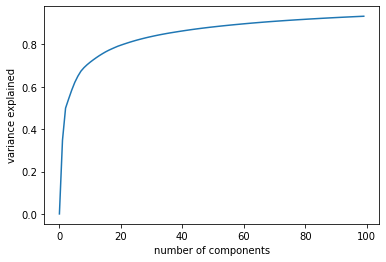

In [14]:
plt.plot(x_axis, var_explained_list)
plt.xlabel("number of components")
plt.ylabel("variance explained")
plt.show()

From the graph above, we see that there will be significant diminishing utility (one extra component explain a diminishing value of extra variance) after around 10 components. Therefore, we will choose n_components = 10.

In [15]:
#Conduct PCA on the data
pca = decomposition.PCA(n_components=10)
pca.fit(X_train)
#transforming the data
X_train_transformed = pca.transform(X_train)
X_test_transformed = pca.transform(X_test)

In [16]:
#Conduct logistic regression on the PCA-ed data
logistic_model_pca = LogisticRegression(max_iter = 1000)
logistic_model_pca.fit(X_train_transformed, y_train)

LogisticRegression(max_iter=1000)

In [17]:
print("Accuracy of PCA-ed logistic regression, training set, is",logistic_model_pca.score(X_train_transformed, y_train))

Accuracy of PCA-ed logistic regression, training set, is 0.6317307692307692


In [18]:
print("Accuracy of PCA-ed logistic regression, test set, is",logistic_model_pca.score(X_test_transformed, y_test))

Accuracy of PCA-ed logistic regression, test set, is 0.6192307692307693


## 4. Logistic regression with LDA ##

In [19]:
#Conducting LDA on the data
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

LinearDiscriminantAnalysis()

In [20]:
#tranforming the data
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

In [21]:
#Conduct logistic regression on the LDA-ed data
logistic_model_lda = LogisticRegression(max_iter = 1000)
logistic_model_lda.fit(X_train_lda, y_train)

LogisticRegression(max_iter=1000)

In [22]:
print("Accuracy of LDA-ed logistic regression, training set, is", logistic_model_lda.score(X_train_lda, y_train))

Accuracy of LDA-ed logistic regression, training set, is 0.9177884615384615


In [23]:
print("Accuracy of LDA-ed logistic regression, test set, is", logistic_model_lda.score(X_test_lda, y_test))

Accuracy of LDA-ed logistic regression, test set, is 0.6076923076923076


## 5. Results ##

From the above implementation, we have the following results:

a. Logistic Regression:

Train accuracy: 0.90

Test accuracy: 0.61

b. Logistic Regression with PCA: 

Train accuracy: 0.63

Test accuracy: 0.62

c. Logistic Regression with LDA:

Train accuracy: 0.92

Test accuracy: 0.61

Comments:

By definition, Logistic Regression is a linear, supervised learning model that determines if a data point, with its given features (inputs) has a higher or lower probability of being in either class (threshold is often 0.5). Meanwhile, the PCA and the LDA are both methods to generate an alternative representation of the data through dimensionality reduction. However, the difference is that LDA takes the labels into account (it is a supervised learning method), while the PCA does not (it is an unsupervised learning method). The PCA also significantly simplifies the data (we reduced to only the top 10 components above).

Since supervised learning models are trained using labels, they often give a more accurate results on the training set. However, unsupervised learning models may yield more generalizable results - that is, the accuracy of the test set and the training set is not too different. 

This is shown through the result - using PCA decreases the accuracy of the training set, as it does not use the labels. The remaining two models, logistic regression and logistic regression with LDA, does significantly better in the training set thanks to using the labels to train. However, we see that there is overfitting in those two models - when it comes to the test set, all three methods have quite similar results. 

